**This is the python code for the Seminar Project SENTIMENT ANALYSIS AMONG THREE SPIRITUAL EMOTIONS by Elma Pusharaja and Viviane Walker**


Seminar: Language Technology for Social Media Analysis

Offered by: The Departement of Computational Linguistics and the Departement of Communication Science and Media Research

Author: Viviane Walker

Date: Jan 2024

# Essential installs and imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Data (Preprocessing)
- import dictionary and filter relevant keywords
- keyword translations (manual)
- data collection with R
- data preprocessing for the sentiment analyses

## Spiritual Emotions Keywords


In [2]:
dest = open('pone.0239050.s003.dic', 'rb').read()
dest_decoded = dest.decode('latin1')
dest_final = dest_decoded.split("\r\n")
dest_final = [ele.split("\t") for ele in dest_final]

# checkpoint:
#print(dest)
#print(dest_decoded)
#print(dest_final)

In [3]:
#create lists with emotion keywords

key_awe = []       #category 02
key_gratitude = [] #category 03
key_hope = []      #category 06

for i in range(9, len(dest_final)): # start: 9 because of category legend in the header of the dic file

  word = dest_final[i][0]

  for ii in range(1, len(dest_final[i])): #['cherish', '05', '06']
    if dest_final[i][ii] == "02":
      key_awe.append(word)
    elif dest_final[i][ii] == "03":
      key_gratitude.append(word)
    elif dest_final[i][ii] == "06":
      key_hope.append(word)
    else:
      continue # skip other emotions keywords


print(len(key_awe))       #59
print(len(key_gratitude)) #61
print(len(key_hope))      #97
print(key_awe)
print(key_gratitude)
print(key_hope)

59
61
97
['admir*', 'aesthetic', 'amazing', 'amazed', 'astonish*', 'awake*', 'awe*', 'beaut*', 'breathtak*', 'brilliant', 'captivat*', 'christ*', 'courage*', 'curiosity', 'delight*', 'devot*', 'divin*', 'enchant*', 'engag*', 'enlight*', 'enliven*', 'esteem*', 'evok*', 'excit*', 'fascinat*', 'god*', 'goosebump*', 'grand*', 'grat*', 'great', 'humility', 'incomprehens*', 'inspir*', 'interest*', 'invigorat*', 'lord', 'lov*', 'magnific*', 'majest*', 'mighty', 'mind-bending', 'mind-blowing', 'mind-boggling', 'mirac*', 'myst*', 'power*', 'prais*', 'raptur*', 'remark*', 'respect*', 'rever*', 'shock*', 'specta*', 'spirit*', 'stimulat*', 'stunning', 'wisdom', 'wonder*', 'worship*']
['acknowledg*', 'admir*', 'affection', 'almighty', 'appreciat*', 'belove*', 'benevolen*', 'bestow*', 'bless*', 'charit*', 'christ*', 'compassion*', 'content*', 'credit', 'dedicat*', 'delight*', 'devot*', 'donat*', 'earn*', 'esteem*', 'favor*', 'forgiv*', 'fulfill*', 'genero*', 'gift', 'goodness', 'grace', 'grat*', 'ha

I copied these lists to a word document in order to translate them manually

## Data Collection

This is done with R which supports keyword based reddit post extraction thanks to the RedditExtractoR package by Ivan Rivera.

TODO link file in the github repo

# Datasets import
I import here the three datasets created in the R file with the three translated keyword lists from above

In [4]:
awe_df_all = pd.read_csv("data/awe_reddit_data.csv")
gratitude_df_all = pd.read_csv("data/gratitude_reddit_data.csv")
hope_df_all = pd.read_csv("data/hope_reddit_data.csv")

## Data Preprocessing

random sampling 2500 rows from each dataframe


2500 because it is the size of the smallest dataset and the goal is to compare overall sentiment of all three dataset hence the datasets must be of equal number of rows.

In [5]:
# before
print(len(awe_df_all))
print(len(gratitude_df_all))
print(len(hope_df_all))

4021
3865
7691


In [6]:
# check for NaNs in title and text column
print("NaNs in awe dataset: ", awe_df_all["text"].isna().sum())
awe_df_all_nonans = awe_df_all.dropna(subset=["text"])
print(len(awe_df_all_nonans))

print("NaNs in gratitude dataset: ", gratitude_df_all["text"].isna().sum())
gratitude_df_all_nonans = gratitude_df_all.dropna(subset=["text"])
print(len(gratitude_df_all_nonans))

print("NaNs in hope dataset: ", hope_df_all["text"].isna().sum())
hope_df_all_nonans = hope_df_all.dropna(subset=["text"])
print(len(hope_df_all_nonans))

NaNs in awe dataset:  1334
2687
NaNs in gratitude dataset:  854
3011
NaNs in hope dataset:  1684
6007


In [7]:
awe_df = awe_df_all_nonans.sample(2500, random_state=13)
gratitude_df = gratitude_df_all_nonans.sample(2500, random_state=13)
hope_df = hope_df_all_nonans.sample(2500, random_state=13)

In [8]:
# checkpoint, should print 2500,  3 times
print(len(awe_df))
print(len(gratitude_df))
print(len(hope_df))

2500
2500
2500


# German Sentiment Analysis

from the repo: https://github.com/oliverguhr/german-sentiment-lib

In [9]:
from germansentiment import SentimentModel
model = SentimentModel()
# fyi: here I get a warning concerning the ssl module... which is a apple specific package collision of urllib3 and ssl

/Users/vi/Desktop/github/SA_emotions/.venv/sa_emotions/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/vi/Desktop/github/SA_emotions/.venv/sa_emotions/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
def batchwise_sa(df):

    batch_size = 100 # through trial and error: this is an optimal batch size
    num_batches = int(np.ceil(len(df) / batch_size))

    classes = []
    pos_probs = []
    neg_probs = []
    neut_probs = []

    # looping through batches of each df
    for i in range(num_batches):
        print(f"STATUS: currently processing batch nr. {i} of {num_batches}") # printing status because, why not :)

        # create batch with index slicing iloc
        start_i = i * batch_size
        end_i = min((i + 1) * batch_size, len(df))
        batch_texts = df["text"].iloc[start_i:end_i]

        # get sentiment classes + probs
        batch_classes, batch_probabilities = model.predict_sentiment(batch_texts, output_probabilities=True)

        # append batch infos to lists
        classes.extend(batch_classes) # ["positive", "neutral", ...]
        pos_probs.extend([ele[0][1] for ele in batch_probabilities]) # [[["positive", 0.3], ["negative", 0.2], ["neutral", 0.5]], [[...],[...],[...]], ...]
        neg_probs.extend([ele[1][1] for ele in batch_probabilities])
        neut_probs.extend([ele[2][1] for ele in batch_probabilities])

    # Add collected batch infos to df
    df["class"] = classes
    df["pos_prob"] = pos_probs
    df["neg_prob"] = neg_probs
    df["neut_prob"] = neut_probs

    print("\nall done :) please check results")


# log: (batch) experiments for awe_df
# 15min+ no batch, 2500 rows
# 12min+ no batch, 500 rows
# 1m 49.9 s batch_size=100, 500 rows
# 1m 44.5 s batch_size=50, 500 rows
# 9m 15.5 s batch_size=100, 2500 rows

## Awe

In [14]:
batchwise_sa(awe_df)

STATUS: currently processing batch nr. 0 of 25
STATUS: currently processing batch nr. 1 of 25
STATUS: currently processing batch nr. 2 of 25
STATUS: currently processing batch nr. 3 of 25
STATUS: currently processing batch nr. 4 of 25
STATUS: currently processing batch nr. 5 of 25
STATUS: currently processing batch nr. 6 of 25
STATUS: currently processing batch nr. 7 of 25
STATUS: currently processing batch nr. 8 of 25
STATUS: currently processing batch nr. 9 of 25
STATUS: currently processing batch nr. 10 of 25
STATUS: currently processing batch nr. 11 of 25
STATUS: currently processing batch nr. 12 of 25
STATUS: currently processing batch nr. 13 of 25
STATUS: currently processing batch nr. 14 of 25
STATUS: currently processing batch nr. 15 of 25
STATUS: currently processing batch nr. 16 of 25
STATUS: currently processing batch nr. 17 of 25
STATUS: currently processing batch nr. 18 of 25
STATUS: currently processing batch nr. 19 of 25
STATUS: currently processing batch nr. 20 of 25
ST

In [15]:
# checkpoint first three rows
print(awe_df[["class", "pos_prob", "neg_prob", "neut_prob"]].head(n=3))

        class  pos_prob  neg_prob  neut_prob
872  negative  0.065826  0.934118   0.000056
283   neutral  0.020076  0.252520   0.727404
642   neutral  0.005588  0.004302   0.990110


## Gratitude

In [16]:
batchwise_sa(gratitude_df)

STATUS: currently processing batch nr. 0 of 25
STATUS: currently processing batch nr. 1 of 25
STATUS: currently processing batch nr. 2 of 25
STATUS: currently processing batch nr. 3 of 25
STATUS: currently processing batch nr. 4 of 25
STATUS: currently processing batch nr. 5 of 25
STATUS: currently processing batch nr. 6 of 25
STATUS: currently processing batch nr. 7 of 25
STATUS: currently processing batch nr. 8 of 25
STATUS: currently processing batch nr. 9 of 25
STATUS: currently processing batch nr. 10 of 25
STATUS: currently processing batch nr. 11 of 25
STATUS: currently processing batch nr. 12 of 25
STATUS: currently processing batch nr. 13 of 25
STATUS: currently processing batch nr. 14 of 25
STATUS: currently processing batch nr. 15 of 25
STATUS: currently processing batch nr. 16 of 25
STATUS: currently processing batch nr. 17 of 25
STATUS: currently processing batch nr. 18 of 25
STATUS: currently processing batch nr. 19 of 25
STATUS: currently processing batch nr. 20 of 25
ST

In [17]:
# checkpoint first three rows
print(gratitude_df[["class", "pos_prob", "neg_prob", "neut_prob"]].head(n=3))

         class  pos_prob  neg_prob  neut_prob
1741   neutral  0.008207  0.014852   0.976941
1143   neutral  0.000402  0.001318   0.998281
2009  negative  0.008977  0.990617   0.000405


## Hope

In [18]:
batchwise_sa(hope_df)

STATUS: currently processing batch nr. 0 of 25
STATUS: currently processing batch nr. 1 of 25
STATUS: currently processing batch nr. 2 of 25
STATUS: currently processing batch nr. 3 of 25
STATUS: currently processing batch nr. 4 of 25
STATUS: currently processing batch nr. 5 of 25
STATUS: currently processing batch nr. 6 of 25
STATUS: currently processing batch nr. 7 of 25
STATUS: currently processing batch nr. 8 of 25
STATUS: currently processing batch nr. 9 of 25
STATUS: currently processing batch nr. 10 of 25
STATUS: currently processing batch nr. 11 of 25
STATUS: currently processing batch nr. 12 of 25
STATUS: currently processing batch nr. 13 of 25
STATUS: currently processing batch nr. 14 of 25
STATUS: currently processing batch nr. 15 of 25
STATUS: currently processing batch nr. 16 of 25
STATUS: currently processing batch nr. 17 of 25
STATUS: currently processing batch nr. 18 of 25
STATUS: currently processing batch nr. 19 of 25
STATUS: currently processing batch nr. 20 of 25
ST

In [19]:
# checkpoint first three rows
print(hope_df[["class", "pos_prob", "neg_prob", "neut_prob"]].head(n=3))

         class  pos_prob  neg_prob  neut_prob
565    neutral  0.011417  0.037844   0.950738
2883   neutral  0.006552  0.036898   0.956550
1384  negative  0.002367  0.997217   0.000417


# Visualizations

In [35]:
palette_here = sns.color_palette("colorblind")

## Descriptive Stats
- most five frequent keywords of each emotion
- sentiment classes frequency of each emotion

<Axes: title={'center': 'Awe: frequencies of all search keywords'}, ylabel='search_keyword'>

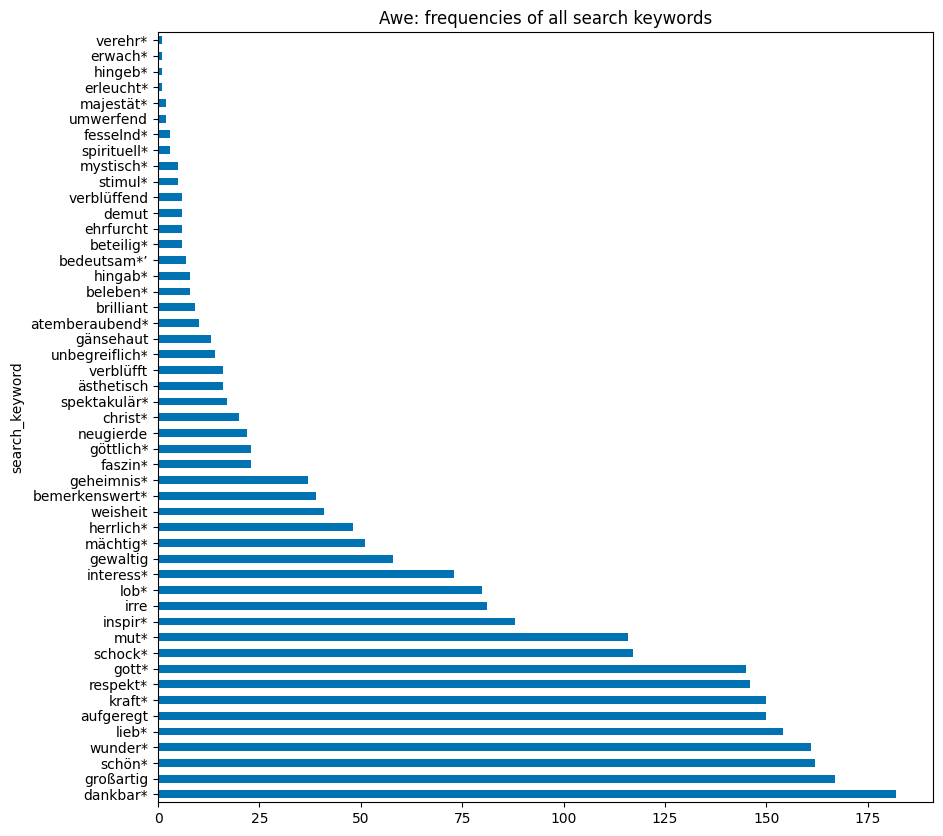

In [48]:
# freq keywords

plt.figure(figsize=(10, 10))
awe_df["search_keyword"].value_counts().plot(kind="barh", color=palette_here[0], title="Awe: frequencies of all search keywords")

<Axes: title={'center': 'Gratitude: frequencies of all search keywords'}, ylabel='search_keyword'>

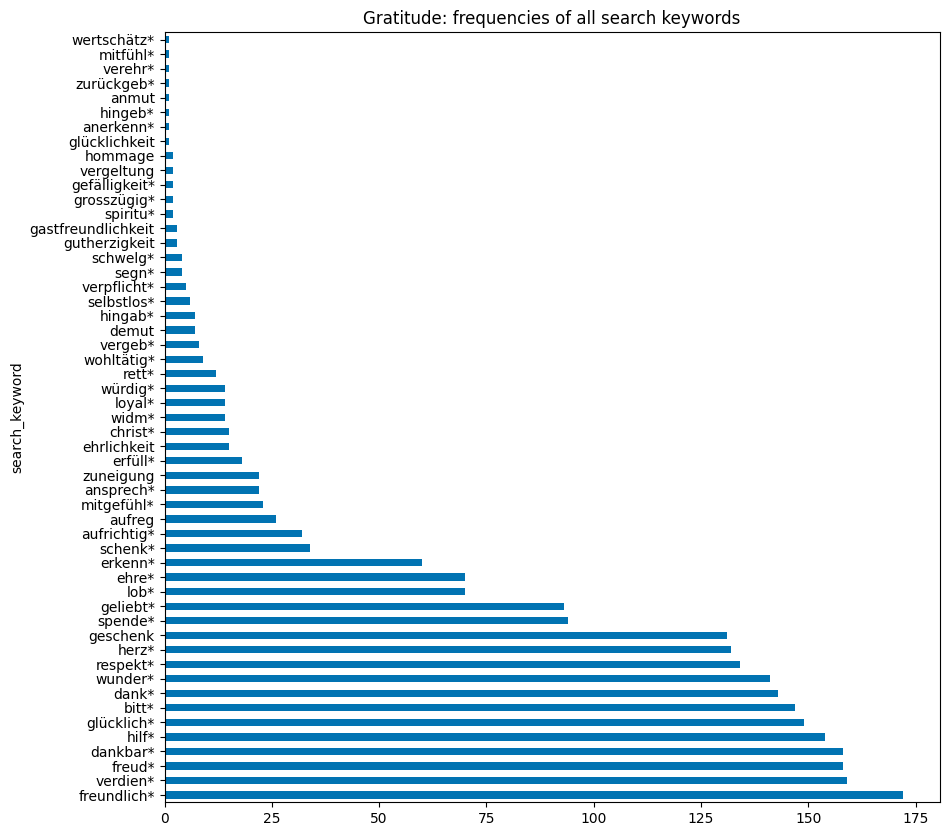

In [52]:
plt.figure(figsize=(10, 10))
gratitude_df["search_keyword"].value_counts().plot(kind="barh", color=palette_here[0], title="Gratitude: frequencies of all search keywords")

<Axes: title={'center': 'Hope: frequencies of all search keywords'}, ylabel='search_keyword'>

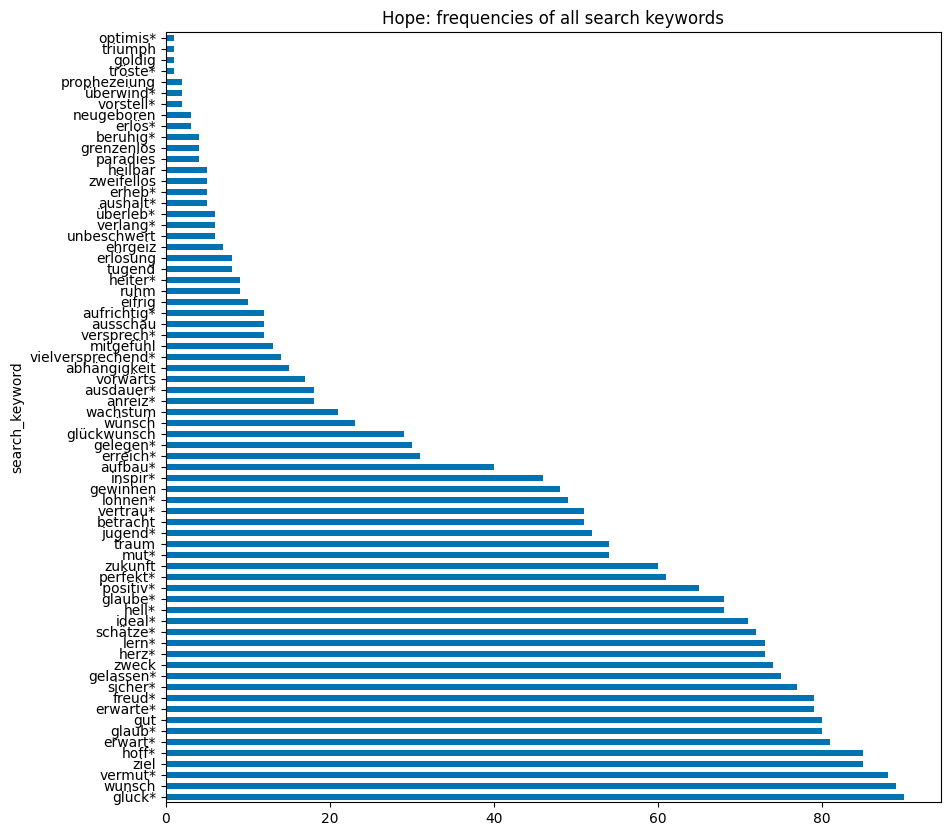

In [53]:
plt.figure(figsize=(10, 10))
hope_df["search_keyword"].value_counts().plot(kind="barh", color=palette_here[0], title="Hope: frequencies of all search keywords")

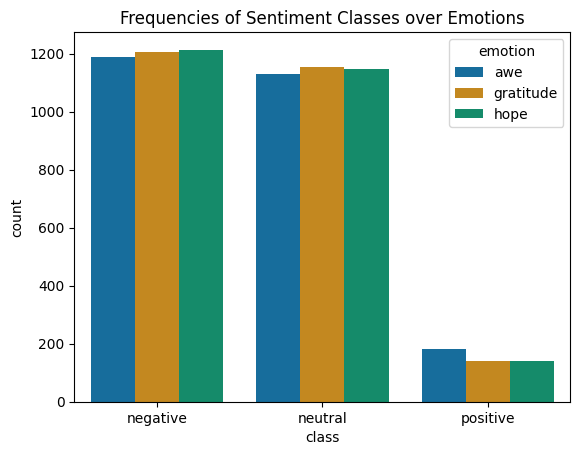

In [64]:
# freq classes
# awe_df["class"].value_counts().plot(kind='bar')

# freqs of all three in one plot
all_df = pd.concat([awe_df, gratitude_df, hope_df])
all_df['emotion'] = 2500*["awe"] + 2500*["gratitude"] + 2500*["hope"]

sns.countplot(data = all_df, x="class", hue="emotion", palette=palette_here[:3])
plt.title('Frequencies of Sentiment Classes over Emotions')
plt.show()

## Hypothesis 1 - degree of positivity

In [62]:
# better a latex table with overall positive probs
overall_pos_awe = awe_df["pos_prob"].values.sum()
print(overall_pos_awe/2500)
overall_pos_gratitude = gratitude_df["pos_prob"].values.sum()
print(overall_pos_gratitude/2500)
overall_pos_hope = hope_df["pos_prob"].values.sum()
print(overall_pos_hope/2500)

0.07926776995231466
0.06552237862774928
0.0631773877253704


# Save Results as CSV for later

In [66]:
awe_df.to_csv(path_or_buf="results/awe_sentiment.csv")
gratitude_df.to_csv(path_or_buf="results/gratitude_sentiment.csv")
hope_df.to_csv(path_or_buf="results/hope_sentiment.csv")
all_df.to_csv(path_or_buf="results/all_sentiment.csv")
